# SECTION 5.3: SUCCESSIVE EPISODES -- SCATTER

In [1]:
#######################################################################################################

# GENERAL THINGS TO DEFINE

#######################################################################################################
directory='/cs/sci/freundlich/CUSPCORE/NIHAO_data/'
rmin_fit=0.01
rmax_fit=1.
polyorder=3
sigma = 11
mode= 'interp'
double_smooth=False
linear_slopes=False
m_constraint=2.
rmin_evolve=10**-1.75
rmax_evolve=1
fitname='lsfit_brho_b2_g3_unconstrained'
limits=[-2,-1,2,3]
delta_xlim=[-2,-1.5]
delta_ymin=-1.
textfont=20
Dsnapshot_threshold=0.1

limits=[-2., -1,-1., 0.1]
limits_fprofile=[-2.2, 0.2, -0.05, 0.55]

#######################################################################################################

import os
import sys
import glob
from scipy import stats
import pickle
import scipy
from scipy.special import erf

import treal_functions
import general_functions
import slopes_functions
import prepare_functions
import fitting as fit
import cuspcore_aux
import cuspcore_plots
import evolving
import cuspcore_go

reload(treal_functions)
reload(general_functions)
reload(slopes_functions)
reload(prepare_functions)
reload(fit)
reload(cuspcore_aux)
reload(cuspcore_plots)
reload(evolving)
reload(cuspcore_go)

from general_functions import *
from slopes_functions import *
from prepare_functions import *
from cuspcore_aux import *
from cuspcore_plots import *
from evolving import *

#######################################################################################################

# Define successions
def find_successions(arr,N):
    newarr=[]
    if N==1:
        for i in range(len(arr)):
            newarr.append(array([arr[i]]))
    else:
        for i in range(len(arr)-N):
            j=1
            while arr[i+j]==arr[i]+j:
                j+=1
                if j==N: 
                    newarr.append(array(arr[i:i+N]))
                    break
    return newarr

#######################################################################################################
# Difference between two lists
def Diff(A,B):
    diff=[]
    na=size(A)
    nb=size(B)
    if na>=nb:
        for i in range(na):
            counter=0
            for j in range(nb):
                if all(A[i]==B[j]): 
                    counter+=1
            if counter==0: diff.append(A[i])
    else:
        for i in range(nb):
            counter=0
            for j in range(na):
                if all(B[i]==A[j]): 
                    counter+=1
            if counter==0: diff.append(B[i])
    return diff

#######################################################################################################
# FIGURE PROPERTIES

fontsize=20
legendsize=fontsize
linewidth=2
linesize=5
ticksize=fontsize-4
figsize=(8,16)
figsize=(8,6)

rcParams['axes.linewidth'] = 1
rcParams['xtick.major.size'] = 6
rcParams['xtick.major.width'] = 1
rcParams['xtick.minor.size'] = 3
rcParams['xtick.minor.width'] = 1
rcParams['ytick.major.size'] = 6
rcParams['ytick.major.width'] = 1
rcParams['ytick.minor.size'] = 3
rcParams['ytick.minor.width'] = 1
rcParams['xtick.labelsize'] = fontsize
rcParams['ytick.labelsize'] = fontsize

rcParams['figure.subplot.left']=0.15
rcParams['figure.subplot.right']=0.95
rcParams['figure.subplot.bottom']=0.15
rcParams['figure.subplot.top']=0.95
rcParams['figure.subplot.wspace']=0.1
rcParams['figure.subplot.hspace']=0.1

#######################################################################################################


/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import glob
sims=[sim[52:60] for sim in glob.glob('/cs/sci/freundlich/CUSPCORE/ARTICLE/output_20190503_g[!s]*[!temp].pickle')]
print sims

['g1.57e11', 'g4.99e10', 'g3.21e11', 'g3.44e10', 'g3.59e11', 'g6.12e10', 'g2.04e11', 'g4.27e10', 'g4.94e10', 'g5.05e10', 'g2.19e11', 'g6.37e10', 'g3.49e11', 'g1.08e11', 'g1.64e11', 'g2.54e11', 'g4.48e10', 'g9.59e10', 'g2.94e10', 'g4.90e11', 'g5.46e11', 'g4.86e10', 'g6.91e10', 'g6.96e10', 'g2.41e11', 'g6.77e10', 'g8.89e10', 'g3.55e11', 'g1.37e11', 'g1.59e11', 'g3.23e11', 'g1.52e11', 'g1.05e11']


In [3]:
import os
for sim in sims:
    output_file_delta='/cs/sci/freundlich/CUSPCORE/ARTICLE/output_%s_delta_successive_all_unconstrained.pickle'%sim
    if not os.path.isfile(output_file_delta):
        print sim, 'no'
print '---'

---


In [ ]:
'''
# DO ALL SUCCESSIVE FOR ALL GALAXIES 

#sims=[sim[52:60] for sim in glob.glob('/cs/sci/freundlich/CUSPCORE/ARTICLE/output_20190503_g[!s]*[!temp].pickle')]
#sims=['g4.99e10']
sims=['g1.08e11']

t_min=3.
merger_thr=0.1
    
for sim in sims:
  print sim
  output_file_delta='/cs/sci/freundlich/CUSPCORE/ARTICLE/output_%s_delta_successive_all_unconstrained.pickle'%sim
  if ~os.path.isfile(output_file_delta):
    imin=0
    if sim=='g6.77e10': imin=1
    if sim=='g3.49e11': imin=6
    if sim=='g6.12e10': imin=27
    ####################################################
    # Definition of a_array
    with open(directory+'NIHAO-1.08e11.pickle') as f:
        gl = pickle.load(f)
    a_array=[]
    for (i,ss) in zip(range(size(gl)),gl):
        a_array.append(ss['a'])         
    a_array=array(a_array)  
    ####################################################
    # Do profile fits

    rlim=[log10(rmin_fit),log10(rmax_fit)] 
    ok_fangzhou,r12_fangzhou,rvir_fangzhou,mvir_fangzhou,mstar_fangzhou=get_fangzhou_radii(sim,a_array,get_stars=True)

    with open(directory+'NIHAO-%s.pickle'%sim[1:]) as f:
        gl = pickle.load(f)
    gl[imin:] = slopes_functions.derive_slopes(gl[imin:],polyorder=polyorder,sigma=sigma,mode=mode,double_smooth=double_smooth,rlim=rlim,use_fangzhou_Rvir=True,linearize=True,betanull=False)
    gl[imin:] = prepare_functions.define_brho(gl[imin:],polyorder=polyorder,sigma=sigma,mode=mode,double_smooth=double_smooth,rlim=rlim,use_fangzhou_Rvir=True)
    fitrange=prepare_functions.get_fitrange(gl,use_fangzhou_Rvir=True,component='d')
    fitrange={'all':fitrange['all'][imin:],'d':fitrange['d'][imin:],'s':fitrange['s'][imin:],'g':fitrange['g'][imin:]}
    gl[imin:]=prepare_functions.reduce_range_gl(gl[imin:],fitrange)

    gl[imin:]=fit.do_fits(gl[imin:],rvir_fangzhou[imin:],mvir_fangzhou[imin:],rmax_fit,rmin_fit,m_constraint,components=['d'])
    ####################################################
    # Define params
    n_outputs=size(gl)

    params=[]
    for i in range(n_outputs):
        try:
            params.append(gl[i]['d'][fitname]['p'])
        except:
            params.append(nan)
    ####################################################
    # Define the mass change m
    x=logspace(-2,0,100)
    r=[]
    m=[]
    for i in range(n_outputs):
        if i>imin:
            if isnan(rvir_fangzhou[i]):
                r.append(nan)
                m.append(nan)
            else:
                r.append(x*rvir_fangzhou[i])
                mi=[]
                for rj in r[i]:
                    mi.append(get_m(gl[i],rj))
                mi=array(mi)
                m.append(mi)
        else:
            r.append(nan)
            m.append(nan)
    ####################################################
    # Define parameters for Tmulti
    Mratio=[]
    Mn=[]
    for i in range(n_outputs):
        try:
            ssi=gl[i]
            Rviri=rvir_fangzhou[i]
            M_rmin=max(ssi['d']['r'][0],ssi['all']['r'][0])
            M_d = ssi['d']['M'][where(ssi['d']['r']>M_rmin)]
            M_a = ssi['all']['M'][where(ssi['d']['r']>M_rmin)]
            M_rr=ssi['d']['r'][where(ssi['d']['r']>M_rmin)]
            M_ratio=M_a/M_d

            slope, intercept,_,_,_ = stats.linregress(log10(M_rr/Rviri),log10(M_ratio))
            Mratio.append(10**intercept)
            Mn.append(-slope)
        except:
            Mratio.append(nan)
            Mn.append(nan)
    ####################################################
    # Define t1_array, fmerger, previous_fmerger
    output_file_sim='/cs/sci/freundlich/CUSPCORE/ARTICLE/output_20190503_%s.pickle'%sim
    with open(output_file_sim) as f:
        output_sim = pickle.load(f)

    [percent_tot,t1_array,t2_array,Dsnapshot,delta,delta_i,fmean,fstd,fmerger,fprofile, fprofile_simname,criteria_threshold]=output_sim  
    t1_array=array(t1_array[0]).copy()
    t2_array=array(t2_array[0]).copy()
    time=t2_array
    fmerger=array(fmerger[0]).copy()
    previous_fmerger=array([nan]+fmerger[:-1].tolist()).copy()
    
    ##########################################
    # Define relevent selection with and without mergers

    relevent_fangzhou=ones(size(rvir_fangzhou),dtype=bool)
    for i in range(size(rvir_fangzhou)):
        if isnan(rvir_fangzhou[i]):
            relevent_fangzhou[i]=False
            if i<>size(rvir_fangzhou)-1:relevent_fangzhou[i+1]=False

    relevent_nomergers=where((relevent_fangzhou) & (t1_array>t_min) & (abs(fmerger) < merger_thr)&(array(range(size(gl)))>imin))
    relevent_nomergers=relevent_nomergers[0]

    relevent_3Gyr=where((relevent_fangzhou) & (t1_array>t_min)&(array(range(size(gl)))>imin))
    relevent_3Gyr=relevent_3Gyr[0]

    ##########################################
    # DEFINE SUCCESSIONS

    '''
    # WITHOUT MERGERS
    N=1
    successions_nomergers=[]
    while find_successions(relevent_nomergers,N)<>[]:
        successions_nomergers+=find_successions(relevent_nomergers,N)
        N+=1

    nsuccessions_nomergers=shape(successions_nomergers)[0]

    # Define N_successions the number of timesteps in each succession
    N_successions_nomergers=[]
    for (isuccession,succession) in zip(range(nsuccessions_nomergers),successions_nomergers):
        N_successions_nomergers.append(size(succession))
    N_successions_nomergers=array(N_successions_nomergers)   
    '''
    
    # ALL AFTER 3 GYR
    N=1
    successions_3Gyr=[]
    while find_successions(relevent_3Gyr,N)<>[]:
        successions_3Gyr+=find_successions(relevent_3Gyr,N)
        N+=1

    nsuccessions_3Gyr=shape(successions_3Gyr)[0]

    # Define N_successions the number of timesteps in each succession
    N_successions_3Gyr=[]
    for (isuccession,succession) in zip(range(nsuccessions_3Gyr),successions_3Gyr):
        N_successions_3Gyr.append(size(succession))
    N_successions_3Gyr=array(N_successions_3Gyr)   

    '''
    
    # ONLY WITH MERGERS

    successions_mergers=Diff(successions_nomergers,successions_3Gyr)
    nsuccessions_mergers=shape(successions_mergers)[0]
    N_successions_mergers=[]
    for (isuccession,succession) in zip(range(nsuccessions_mergers),successions_mergers):
        N_successions_mergers.append(size(succession))
    N_successions_mergers=array(N_successions_mergers)   

    print '  Nombre de successions sans mergers: ', nsuccessions_nomergers
    print '  Nombre de successions avec mergers: ', nsuccessions_mergers
    print '  Nombre total de successions: ', nsuccessions_3Gyr
    '''
    ##########################################

    # TEST MODEL OVER SUCCESSIONS OF SNAPSHOTS // SUCCESSIVE MASS CHANGES

    delta_successive=zeros(nsuccessions_3Gyr)
    delta_successive=zeros(nsuccessions_3Gyr)
    pi_successive=[(nan,nan,nan,nan,nan,nan)]*nsuccessions_3Gyr
    pf_successive=[(nan,nan,nan,nan,nan,nan)]*nsuccessions_3Gyr
    pmodel_successive=[(nan,nan,nan,nan,nan,nan)]*nsuccessions_3Gyr
    ismerger_successive=[nan]*nsuccessions_3Gyr

    for (isuccession,succession) in zip(range(nsuccessions_3Gyr),successions_3Gyr):
        Ns=N_successions_3Gyr[isuccession]

        ki=succession[0]-1
        kf=succession[-1]

        ssi=gl[ki]
        ssf=gl[kf]
        ti= ssi['t']
        tf= ssf['t']
        ri=ssi['d']['r']
        rf=ssf['d']['r']
        paramsi=params[ki]
        paramsf=params[kf]
        Rviri=rvir_fangzhou[ki]
        Rvirf=rvir_fangzhou[kf]

        brhoi = ssi['d']['brho']
        brhofiti = prf.brho(ri,paramsi)
        brhov = brhoi[0]

        brhof = ssf['d']['brho']
        brhofitf = prf.brho(rf,paramsf)

        wcore = 0*(rf<=rmin_evolve*Rvirf)+1*((rf>rmin_evolve*Rvirf)&(rf<=rmax_evolve*Rvirf))+0*(rf>rmax_evolve*Rvirf)

        paramsk=paramsi
        count_mergers=0
        for i in range(Ns):
            k=ki+i

            mk=[]
            for rf_i in rf:
                mk.append(get_m(gl[k+1],rf_i))
            mk=array(mk)    

            Mk=prf.M(rf, paramsk)
            add_params=[Mratio[k],Mn[k]]

            res = evolve(rf, rf, Mk, paramsk, mk,Ttype='Tmulti', w=wcore,add_params=add_params)
            paramsk = res['pf']
            brhofit_model_k = prf.brho(rf,res['pf'])

            if fmerger[k+1]>merger_thr: count_mergers+=1
    
        if count_mergers==0: 
            ismerger_successive[isuccession]=False
            merger_info=''
        else: 
            ismerger_successive[isuccession]=True
            merger_info='(merger)'

        p_model=paramsk
        brhofit_model= prf.brho(rf,p_model)

        maxr = rmax_fit*Rvirf
        rr=rf[rf<=maxr]
        Darea=fit.Delta_area(log10(rr/Rvirf),log10(prf.brho(rr, paramsf)/brhov),log10(prf.brho(rr, p_model)/brhov),xlimits=delta_xlim,ymin=delta_ymin)

        delta_successive[isuccession]=Darea
        pi_successive[isuccession]=paramsi
        pf_successive[isuccession]=paramsf
        pmodel_successive[isuccession]=paramsk
    
        print '%i/%i:'%(isuccession,nsuccessions_3Gyr),'ki=', ki, 'kf=',kf, 'ti=%.2f Gyr'%ti, 'tf=%.2f Gyr'%tf, 'delta=%.2f'%Darea, merger_info

    output_file_delta='/cs/sci/freundlich/CUSPCORE/ARTICLE/output_%s_delta_successive_all_unconstrained.pickle'%sim
    with open(output_file_delta, 'w') as f:
        pickle.dump([successions_3Gyr,N_successions_3Gyr,delta_successive,pi_successive,pf_successive,pmodel_successive,ismerger_successive], f)

print 'Done!'

'''

In [4]:
Ds_if_all=array([])
Ds_model_all=array([])
Dc_if_all=array([])
Dc_model_all=array([])
Deltas_all=array([])
Deltac_all=array([])
delta_all=array([])
N_successions_all=array([])
ismerger_successions_all=array([])

for sim in sims:
    output_file_delta='/cs/sci/freundlich/CUSPCORE/ARTICLE/output_%s_delta_successive_all_unconstrained.pickle'%sim
    if os.path.isfile(output_file_delta):
        print sim,
        with open(output_file_delta) as f:
            [successions,N_successions,delta_successive,pi_successive,pf_successive,pmodel_successive,ismerger_successive]=pickle.load(f)
        print size(successions)
    
    nsuccessions=size(successions)
    si=nan*ones(nsuccessions)
    sf=nan*ones(nsuccessions)
    smodel=nan*ones(nsuccessions)
    ci=nan*ones(nsuccessions)
    cf=nan*ones(nsuccessions)
    cmodel=nan*ones(nsuccessions)
    
    for (isuccession,succession) in zip(range(nsuccessions),successions):
        si[isuccession]=prf.s(rmin_fit*pi_successive[isuccession][4],pi_successive[isuccession])
        sf[isuccession]=prf.s(rmin_fit*pf_successive[isuccession][4],pf_successive[isuccession])
        smodel[isuccession]=prf.s(rmin_fit*pmodel_successive[isuccession][4],pmodel_successive[isuccession])
        ci[isuccession]=prf.cmax(pi_successive[isuccession])
        cf[isuccession]=prf.cmax(pf_successive[isuccession])
        cmodel[isuccession]=prf.cmax(pmodel_successive[isuccession])
        delta=delta_successive[isuccession]
    
    Ds_if=sf-si
    Ds_model=smodel-si
    Dc_if=cf/ci
    Dc_model=cmodel/ci
    Deltas=abs((smodel-sf)/sf)
    Deltac=abs((cmodel-cf)/cf)
    
    Ds_if_all=concatenate((Ds_if_all,Ds_if),axis=0)
    Ds_model_all=concatenate((Ds_model_all,Ds_model),axis=0)
    Dc_if_all=concatenate((Dc_if_all,Dc_if),axis=0)
    Dc_model_all=concatenate((Dc_model_all,Dc_model),axis=0)
    N_successions_all=concatenate((N_successions_all,N_successions),axis=0)
    ismerger_successions_all=concatenate((ismerger_successions_all,array(ismerger_successive)),axis=0)
    delta_all=concatenate((delta_all,delta_successive),axis=0)
    Deltas_all=concatenate((Deltas_all,Deltas),axis=0)
    Deltac_all=concatenate((Deltac_all,Deltac),axis=0)
    
Dt=0.21576941 # Gyr
Dt_successions_all=N_successions_all*Dt
print 'TOTAL   ', size(N_successions_all)
print 'Done!'


g1.57e11 1226
g4.99e10 869
g3.21e11 1177
g3.44e10 371
g3.59e11 583
g6.12e10 290
g2.04e11 1226
g4.27e10 115
g4.94e10 375
g5.05e10 278
g2.19e11 957
g6.37e10 407
g3.49e11 1226
g1.08e11 1226
g1.64e11 327
g2.54e11 553
g4.48e10 444
g9.59e10 1226
g2.94e10 123
g4.90e11 1226
g5.46e11 1226
g4.86e10 1226
g6.91e10 1226
g6.96e10 919
g2.41e11 1226
g6.77e10 827
g8.89e10 1226
g3.55e11 560
g1.37e11 1226
g1.59e11 1226
g3.23e11 1226
g1.52e11 1226
g1.05e11 542
TOTAL    28107
Done!


# PLOT RPEARSON, SCATTER AS A FUNCTION OF N

In [5]:
Nmin=1
Nmax=30
Nvals=range(Nmin,Nmax)

s0_rpearson_all=[scipy.stats.pearsonr(Ds_if_all[(N_successions_all == i)],Ds_model_all[(N_successions_all == i)])[0] for i in Nvals]
s0_std_all=[std(Ds_if_all[(N_successions_all == i)]-Ds_model_all[(N_successions_all == i)]) for i in Nvals]

s0_rpearson_nomergers=[scipy.stats.pearsonr(Ds_if_all[(N_successions_all == i) & (ismerger_successions_all==0)],Ds_model_all[(N_successions_all == i) & (ismerger_successions_all==0)])[0] for i in Nvals]
s0_std_nomergers=[std(Ds_if_all[(N_successions_all == i) & (ismerger_successions_all==0)]-Ds_model_all[(N_successions_all == i) & (ismerger_successions_all==0)])  for i in Nvals]

s0_rpearson_mergers=[scipy.stats.pearsonr(Ds_if_all[(N_successions_all == i) & (ismerger_successions_all==1)],Ds_model_all[(N_successions_all == i) & (ismerger_successions_all==1)])[0] for i in Nvals]
s0_std_mergers=[std(Ds_if_all[(N_successions_all == i) & (ismerger_successions_all==1)]-Ds_model_all[(N_successions_all == i) & (ismerger_successions_all==1)])  for i in Nvals]

print 'Done!'



Done!


In [6]:
Nmin=1
Nmax=30
Nvals=range(Nmin,Nmax)

cmax_rpearson_all=[scipy.stats.pearsonr(log10(Dc_if_all[(N_successions_all == i)]),log10(Dc_model_all[(N_successions_all == i)]))[0] for i in Nvals]
cmax_std_all=[std(log10(Dc_if_all[(N_successions_all == i)])-log10(Dc_model_all[(N_successions_all == i)])) for i in Nvals]

cmax_rpearson_nomergers=[scipy.stats.pearsonr(log10(Dc_if_all[(N_successions_all == i) & (ismerger_successions_all==0)]),log10(Dc_model_all[(N_successions_all == i) & (ismerger_successions_all==0)]))[0] for i in Nvals]
cmax_std_nomergers=[std(log10(Dc_if_all[(N_successions_all == i) & (ismerger_successions_all==0)])-log10(Dc_model_all[(N_successions_all == i) & (ismerger_successions_all==0)]))  for i in Nvals]

cmax_rpearson_mergers=[scipy.stats.pearsonr(log10(Dc_if_all[(N_successions_all == i) & (ismerger_successions_all==1)]),log10(Dc_model_all[(N_successions_all == i) & (ismerger_successions_all==1)]))[0] for i in Nvals]
cmax_std_mergers=[std(log10(Dc_if_all[(N_successions_all == i) & (ismerger_successions_all==1)])-log10(Dc_model_all[(N_successions_all == i) & (ismerger_successions_all==1)]))  for i in Nvals]

print 'Done!'



Done!


In [7]:
# FIGURE PROPERTIES

fontsize=20
legendsize=fontsize
linewidth=2
linesize=5
ticksize=fontsize-4
figsize=(8,16)
figsize=(8,6)

rcParams['axes.linewidth'] = 1
rcParams['xtick.major.size'] = 6
rcParams['xtick.major.width'] = 1
rcParams['xtick.minor.size'] = 3
rcParams['xtick.minor.width'] = 1
rcParams['ytick.major.size'] = 6
rcParams['ytick.major.width'] = 1
rcParams['ytick.minor.size'] = 3
rcParams['ytick.minor.width'] = 1
rcParams['xtick.labelsize'] = fontsize
rcParams['ytick.labelsize'] = fontsize

rcParams['figure.subplot.left']=0.15
rcParams['figure.subplot.right']=0.95
rcParams['figure.subplot.bottom']=0.15
rcParams['figure.subplot.top']=0.95
rcParams['figure.subplot.wspace']=0.1
rcParams['figure.subplot.hspace']=0.1


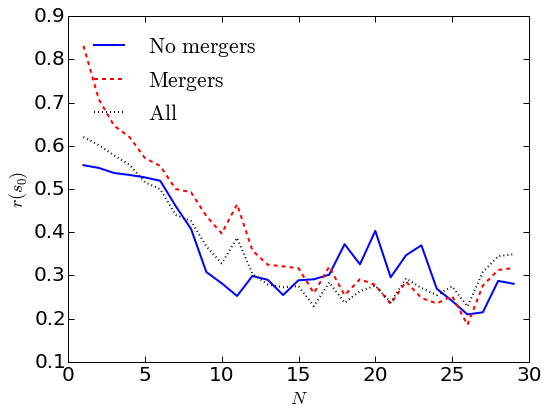

In [8]:

fig, ax = subplots(nrows=1, ncols=1,figsize=figsize)
clf()

ax=gca()

ax.plot(Nvals,s0_rpearson_nomergers,'b',lw=2,label=r'$\rm No$ $\rm mergers$')
ax.plot(Nvals,s0_rpearson_mergers,'r--',dashes=(4,4),lw=2,label=r'$\rm Mergers$')
ax.plot(Nvals,s0_rpearson_all,'k:',lw=2,label=r'$\rm All$')

ax.tick_params(axis='both',direction='in')

xlabel(r'$N$')
ylabel(r'$r(s_{\rm 0})$')
legend(frameon=False,loc='upper left')


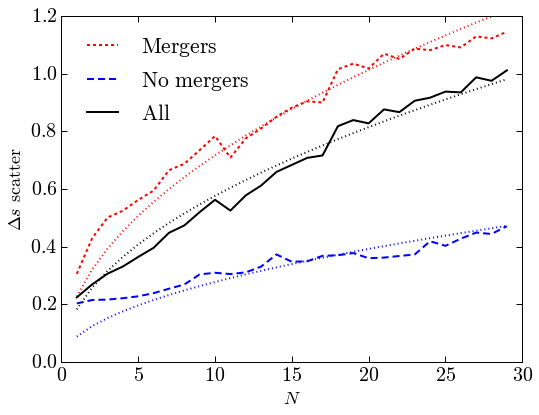

In [9]:
from scipy.optimize import curve_fit
def sqrt_fun(x,a):
    return a*sqrt(x)

fig, ax = subplots(nrows=1, ncols=1,figsize=figsize)
clf()

ax=gca()

ax.plot(Nvals,s0_std_mergers,'r--',dashes=(3,3),lw=2,label=r'$\rm Mergers$')
popt, pcov = curve_fit(sqrt_fun,Nvals,s0_std_mergers,p0=s0_std_mergers[0])
ax.plot(Nvals,sqrt_fun(Nvals,popt[0]),'r:',lw=2)


ax.plot(Nvals,s0_std_nomergers,'b--',dashes=(7,4),lw=2,label=r'$\rm No$ $\rm mergers$')
popt, pcov = curve_fit(sqrt_fun,Nvals,s0_std_nomergers,p0=s0_std_nomergers[0])
ax.plot(Nvals,sqrt_fun(Nvals,popt[0]),'b:',lw=2)

ax.plot(Nvals,s0_std_all,'k',lw=2,label=r'$\rm All$')
popt, pcov = curve_fit(sqrt_fun,Nvals,s0_std_all,p0=s0_std_all[0])
ax.plot(Nvals,sqrt_fun(Nvals,popt[0]),'k:',lw=2)

ax.tick_params(axis='both',direction='in')

xlabel(r'$N$')
ylabel(r'$\Delta s$ $\rm scatter$')
legend(frameon=False,loc='upper left')

axis([0,30,0,1.2])
ax.set_xticks([0,5,10,15,20,25,30])
ax.set_xticklabels([r'$0$',r'$5$',r'$10$',r'$15$',r'$20$',r'$25$',r'$30$'])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1,1.2])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$',r'$1.2$'])


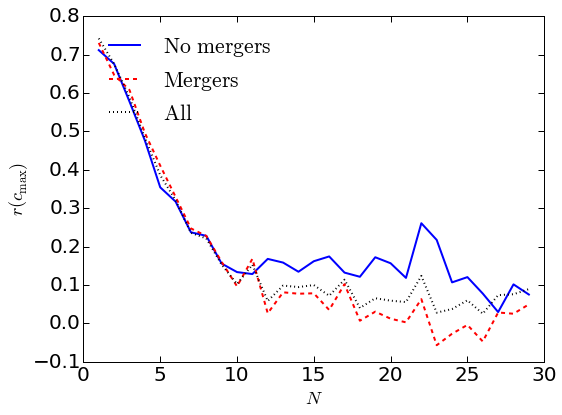

In [10]:

fig, ax = subplots(nrows=1, ncols=1,figsize=figsize)
clf()

ax=gca()



ax.plot(Nvals,cmax_rpearson_nomergers,'b',lw=2,label=r'$\rm No$ $\rm mergers$')
ax.plot(Nvals,cmax_rpearson_mergers,'r--',dashes=(4,4),lw=2,label=r'$\rm Mergers$')
ax.plot(Nvals,cmax_rpearson_all,'k:',lw=2,label=r'$\rm All$')

ax.tick_params(axis='both',direction='in')

xlabel(r'$N$')
ylabel(r'$r(c_{\rm max})$')
legend(frameon=False,loc='upper left')


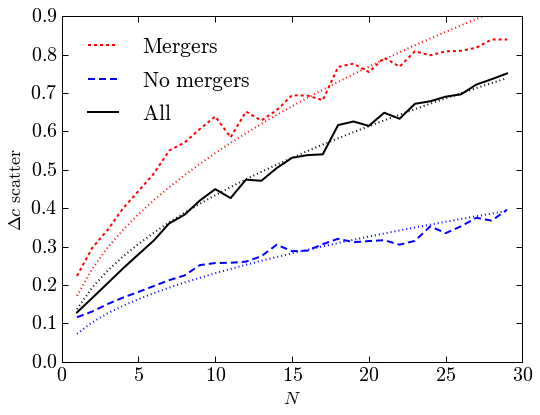

In [12]:

fig, ax = subplots(nrows=1, ncols=1,figsize=figsize)
clf()

ax=gca()

ax.plot(Nvals,cmax_std_mergers,'r--',dashes=(3,3),lw=2,label=r'$\rm Mergers$')
popt, pcov = curve_fit(sqrt_fun,Nvals,cmax_std_mergers,p0=cmax_std_mergers[0])
ax.plot(Nvals,sqrt_fun(Nvals,popt[0]),'r:',lw=2)


ax.plot(Nvals,cmax_std_nomergers,'b--',dashes=(7,4),lw=2,label=r'$\rm No$ $\rm mergers$')
popt, pcov = curve_fit(sqrt_fun,Nvals,cmax_std_nomergers,p0=cmax_std_nomergers[0])
ax.plot(Nvals,sqrt_fun(Nvals,popt[0]),'b:',lw=2)


ax.plot(Nvals,cmax_std_all,'k',lw=2,label=r'$\rm All$')
popt, pcov = curve_fit(sqrt_fun,Nvals,cmax_std_all,p0=cmax_std_all[0])
ax.plot(Nvals,sqrt_fun(Nvals,popt[0]),'k:',lw=2)

ax.tick_params(axis='both',direction='in')

xlabel(r'$N$')
ylabel(r'$\Delta c$ $\rm scatter$')
legend(frameon=False,loc='upper left')

axis([0,30,0,0.9])
ax.set_xticks([0,5,10,15,20,25,30])
ax.set_xticklabels([r'$0$',r'$5$',r'$10$',r'$15$',r'$20$',r'$25$',r'$30$'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ax.set_yticklabels([r'$0.0$',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$',r'$0.8$',r'$0.9$'])


In [13]:
delta_median_all=array([median(delta_all[(N_successions_all == i)]) for i in Nvals])
delta_std_all=array([std(delta_all[(N_successions_all == i)]) for i in Nvals])

delta_median_nomergers=array([median(delta_all[(N_successions_all == i) & (ismerger_successions_all==0)]) for i in Nvals])
delta_std_nomergers=array([std(delta_all[(N_successions_all == i) & (ismerger_successions_all==0)]) for i in Nvals])

delta_median_mergers=array([median(delta_all[(N_successions_all == i) & (ismerger_successions_all==1)]) for i in Nvals])
delta_std_mergers=array([std(delta_all[(N_successions_all == i) & (ismerger_successions_all==1)]) for i in Nvals])

#######

deltas_median_all=[median(Deltas_all[(N_successions_all == i)]) for i in Nvals]
deltas_std_all=[std(Deltas_all[(N_successions_all == i)]) for i in Nvals]

deltas_median_nomergers=[median(Deltas_all[(N_successions_all == i) & (ismerger_successions_all==0)]) for i in Nvals]
deltas_std_nomergers=[std(Deltas_all[(N_successions_all == i) & (ismerger_successions_all==0)]) for i in Nvals]

deltas_median_mergers=[median(Deltas_all[(N_successions_all == i) & (ismerger_successions_all==1)]) for i in Nvals]
deltas_std_mergers=[std(Deltas_all[(N_successions_all == i) & (ismerger_successions_all==1)]) for i in Nvals]

#######

deltac_median_all=[median(Deltac_all[(N_successions_all == i)]) for i in Nvals]
deltac_std_all=[std(Deltac_all[(N_successions_all == i)]) for i in Nvals]

deltac_median_nomergers=[median(Deltac_all[(N_successions_all == i) & (ismerger_successions_all==0)]) for i in Nvals]
deltac_std_nomergers=[std(Deltac_all[(N_successions_all == i) & (ismerger_successions_all==0)]) for i in Nvals]

deltac_median_mergers=[median(Deltac_all[(N_successions_all == i) & (ismerger_successions_all==1)]) for i in Nvals]
deltac_std_mergers=[std(Deltac_all[(N_successions_all == i) & (ismerger_successions_all==1)]) for i in Nvals]

print 'Done!'

Done!


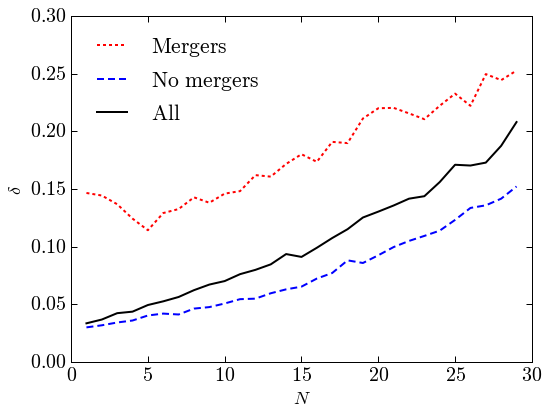

In [16]:
alpha_fill=0.2

fig, ax = subplots(nrows=1, ncols=1,figsize=figsize)
clf()

ax=gca()

ax.plot(Nvals,delta_median_mergers,'r--',dashes=(3,3),lw=2,label=r'$\rm Mergers$')
ax.plot(Nvals,delta_median_nomergers,'b--',dashes=(7,4),lw=2,label=r'$\rm No$ $\rm mergers$')
ax.plot(Nvals,delta_median_all,'k',lw=2,label=r'$\rm All$')

ax.tick_params(axis='both',direction='in')

xlabel(r'$N$')
ylabel(r'$\delta$')
legend(frameon=False,loc='upper left')

axis([0,30,0,0.3])
ax.set_xticks([0,5,10,15,20,25,30])
ax.set_xticklabels([r'$0$',r'$5$',r'$10$',r'$15$',r'$20$',r'$25$',r'$30$'])
ax.set_yticks([0,0.05,0.1,0.15,0.2,0.25,0.3])
ax.set_yticklabels([r'$0.00$',r'$0.05$',r'$0.10$',r'$0.15$',r'$0.20$',r'$0.25$',r'$0.30$'])

savefig('/vol/sci/astro/home/freundlich/CUSPCORE/ARTICLE/figures3/fig_s5_succession_delta.pdf')#, bbox_inches='tight')